### Convolution

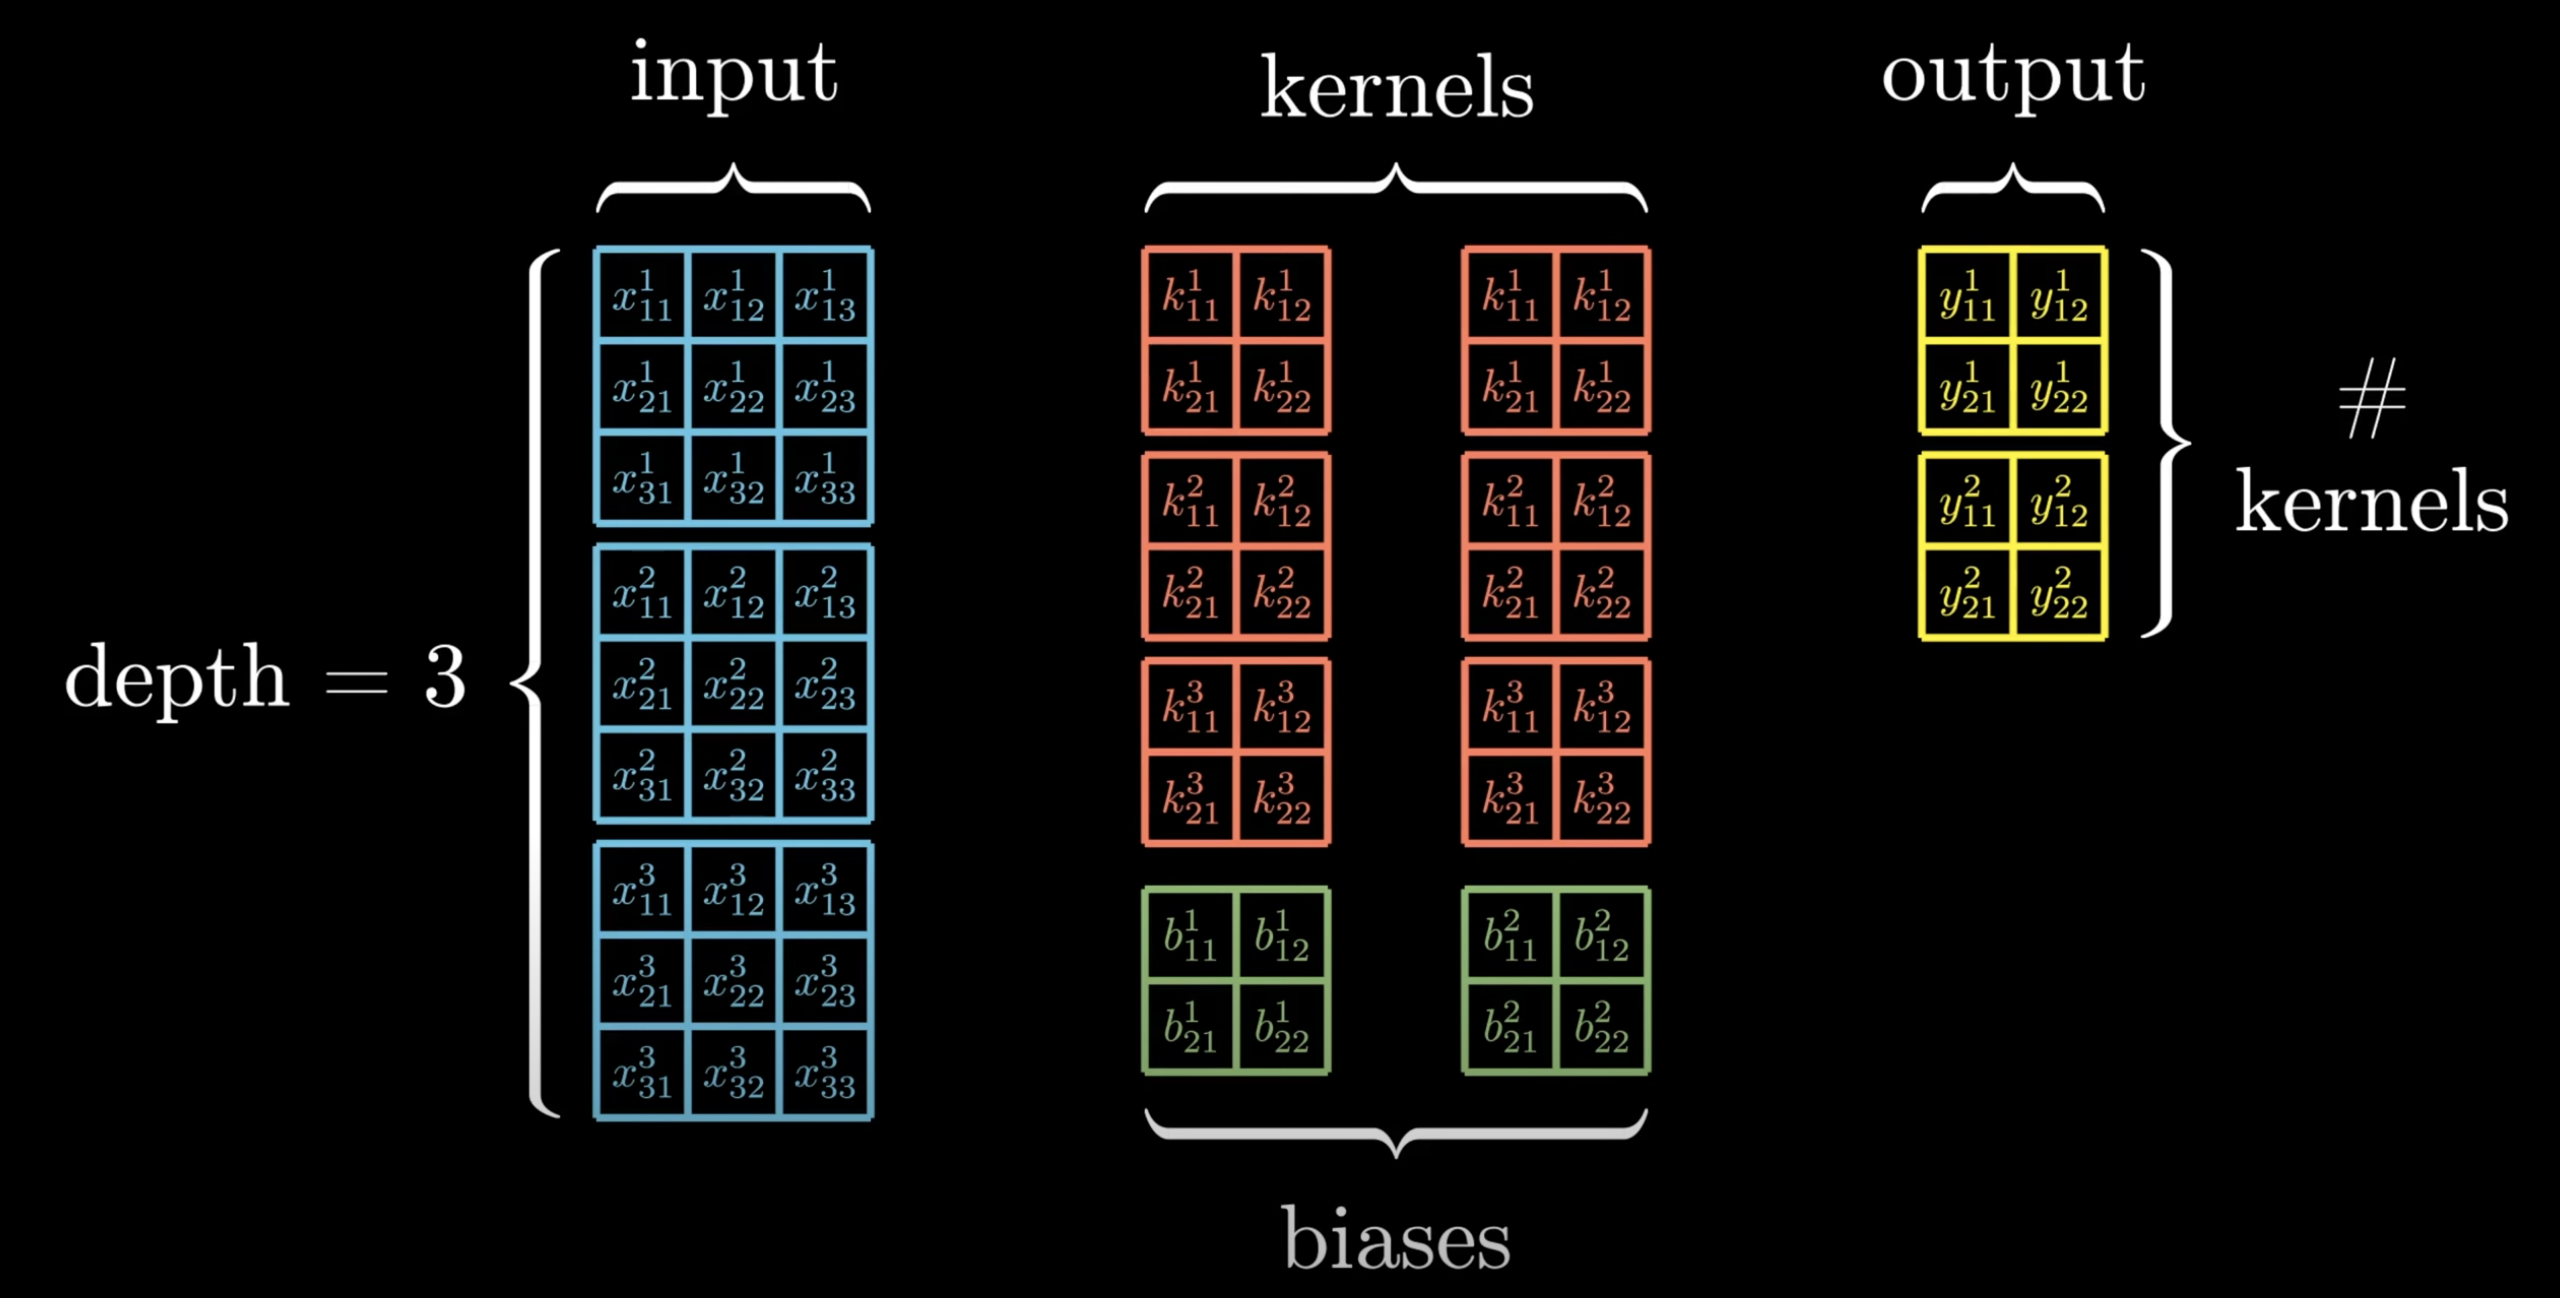

In [2]:
from IPython.display import Image, display

# Display an image by its file path
display(Image(filename='/Users/mackikopro/Desktop/Screen record/Screen Shot 2024-02-10 at 10.14.54 PM.png'))


$$ Y_i = B_i + \sum_{j=1}^{n} X_j \ast K_{ij} $$


In [ ]:
class Convolution(Layer):
    def __init__(self , input_shape , kernel_size , depth):
        # input_shape is the shape of input in tuple , kernel_size is the size of each matrix in each Kernel tensor , depth is how many kernel tensor we want (The depth of the output)
        super().__init__()
        input_depth , input_height , input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth , input_height - kernel_size + 1, input_width - kernel_size + 1) # shape: (i1-k +1 , i2-k +1)
        self.kernel_shape = (depth , input_depth , kernel_size  , kernel_size)  # we have "depth" kernel tensors , Each kernel tensor has "input_depth" matrices , Each matrix has a shape of (kernel_size , kernel_size)
        self.kernels = np.random.randn(*self.kernel_shape)
        self.biases = np.random.randn(*self.output_shape) # The size of each bias matrix is equal to the size of each output matrix
        # Numpy note:  np.random.randn(*shape_tuple) => random number based on the point that each random values will be normally distributed (Mean = 0 , S.D. = 1)
        # Python note: *tuple used to unpack tuple (in this case, shape) and pass it as an argument of the function.


    def forward(self , input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth): # Loop on each element, Y_i in Y
            for j in range(self.input_depth): # Loop for each input matrix, X_j in X
                self.output[i] += signal.correlate2d(self.input[j] , self.kernels[i,j], "valid") # i represent kernel tensor index , while j represent each matrix index in each kernel tensor
                # signal.correlate2d(self.input[j] , self.kernels[i,j], mode = "valid") will have an array (same size as each bias matrix) as the output

        return self.output

$$ \frac{\partial E}{\partial K_{ij}} = X_j \star \frac{\partial E}{\partial Y_i} $$
$$ \frac{\partial E}{\partial B_i} = \frac{\partial E}{\partial Y_i} $$
$$ \frac{\partial E}{\partial X_j} = \sum_{i=1}^{n} \frac{\partial E}{\partial Y_i} \ast_{\text{full}} K_{ij} $$

In [ ]:
def backward(self, output_gradient):
        kernel_grad = np.zeros(self.kernel_shape)
        input_grad = np.zeros(self.input_shape)

        # Update Parameters
        for i in range(self.depth):
            for j in range(self.input_depth):
                kernel_grad[i, j] = signal.correlate2d(self.input[j] , output_gradient[i] , "valid")
                input_grad[j] += signal.convolve2d(output_gradient[i] , self.kernels[i,j] , "full")  # ∂E/∂X_j  = ∑ ∂E/∂Y_i ❊_full K_ij  # This also indicate that every matrix in the Input tenser is updated.

        #kernel_grad = clip_gradient_by_norm(kernel_grad,1e+50)
        self.kernel_grad = kernel_grad
        self.biases_grad = output_gradient
        #self.kernels -= learning_rate * self.kernel_grad  # We can see that the shape of kernel_grad is equal to the kernel in this layer (initialize)
        #self.biases -= learning_rate * self.biases_grad
        return input_grad

#### Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from matplotlib import pyplot as plt

import loss
from dense import Dense
from activation_func import Sigmoid , Softmax
from convolution import Convolution, Reshape
from loss import *
from keras.datasets import mnist
from alive_progress import alive_bar
from model import Sequential
from optimizer import Gradient_Descent
from utility import dataloader
from utility import *

In [2]:
# get the data
def get_mnist():
    (train_images, train_labels) , (test_images , test_labels) = mnist.load_data()
    train_images = train_images.astype("float32") / 255 # Normalized
    test_images = test_images.astype("float32") / 255 # Normalized
    train_images = np.reshape(train_images, (train_images.shape[0],1, train_images.shape[1] , train_images.shape[2])) # match the input of the model (in this case, convolution)
    test_images = np.reshape(test_images, (test_images.shape[0],1, test_images.shape[1] , test_images.shape[2]))
    train_labels = np.eye(10)[train_labels]
    test_labels = np.eye(10)[test_labels]
    train_labels = train_labels.reshape(len(train_images) , 10 , 1)
    test_labels = test_labels.reshape(len(test_images) , 10 , 1)
    return train_images , test_images , train_labels , test_labels



In [3]:
train_images_1 , test_images_1 , train_labels_1 , test_labels_1 = get_mnist()


train_images = train_images_1[:10000]
train_labels = train_labels_1[:10000]

val_images = train_images_1[30001:35001]
val_labels = train_labels_1[30001:35001]

test_images = test_images_1[:1000]
test_labels = test_labels_1[:1000]
print("finished loading data")

# preprocessing
train_list = [train_images , train_labels]
val_list = [val_images , val_labels]

data_train = dataloader(train_list , batch_size= 512 , shuffle= True )
data_val = dataloader(val_list , batch_size=512 , shuffle= True)
print("finished preprocessing")


finished loading data
finished preprocessing


In [4]:
# Defining the model's architecture
model_V1 = Sequential([
    Convolution((1,28,28) , 3, 5 ),
    Sigmoid(),
    Reshape((5,26,26), (5*26*26 , 1)),
    Dense(5*26*26, 100),
    Sigmoid(),
    Dense(100 , 10),
    Softmax()
])

print("finish defining the model's architecture")

# Training the model
print("start of training")
opt = Gradient_Descent(avg_grad_model=[] ,learning_rate=0.01 , momentum=0.9 , acceleration=True)
model_V1.compile(optimizer=opt , loss= loss.mse , metric=["accuracy"])
hist = model_V1.fit(data= data_train , epochs = 2 , validation_data=data_val)
print(hist) 

finish defining the model's architecture
start of training
on 20: finished the loop
Epoch 1 |████████████████████████████████████████| 20 in 1:24.4 (0.24/s) 
on 20: finished the loop
Epoch 2 |████████████████████████████████████████| 20 in 59.5s (0.34/s) 
{'loss_train': [0.17329153463076294, 0.17321843121848368], 'accuracy_score_train': [0.1003, 0.1001], 'loss_validation': [0.17416676471745612, 0.1740929366645731], 'accuracy_score_validation': [0.0922, 0.0954]}
